# Install Dependencies and Setup

In [1]:
# what version of Python do you have?
import sys
import os

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

# check whether the GPU is available
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Python Platform: macOS-13.1-arm64-arm-64bit
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is available


In [2]:
# additional ibraries for tensorflow image cassification tasks
import pathlib # object-oriented filesystem paths
import matplotlib.pyplot as plt
import numpy as np
import PIL # python imaging library for image processing capabilities

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Explore the dataset

In [3]:
# get current working directory
current_dir = os.getcwd()
current_dir

'/Users/marcdeheeger/PythonProjects/MSDS 498/Mushroom Project'

In [6]:
# navigate to directory with image data
cd DraftCode/Images/

/Users/marcdeheeger/PythonProjects/MSDS 498/Mushroom Project/DraftCode/Images


In [10]:
# create pathlib.PosixPath object for directory containing images
data_dir = 'data_gp'
data_dir = pathlib.Path(data_dir)

In [11]:
# number of images in the image directory
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

444


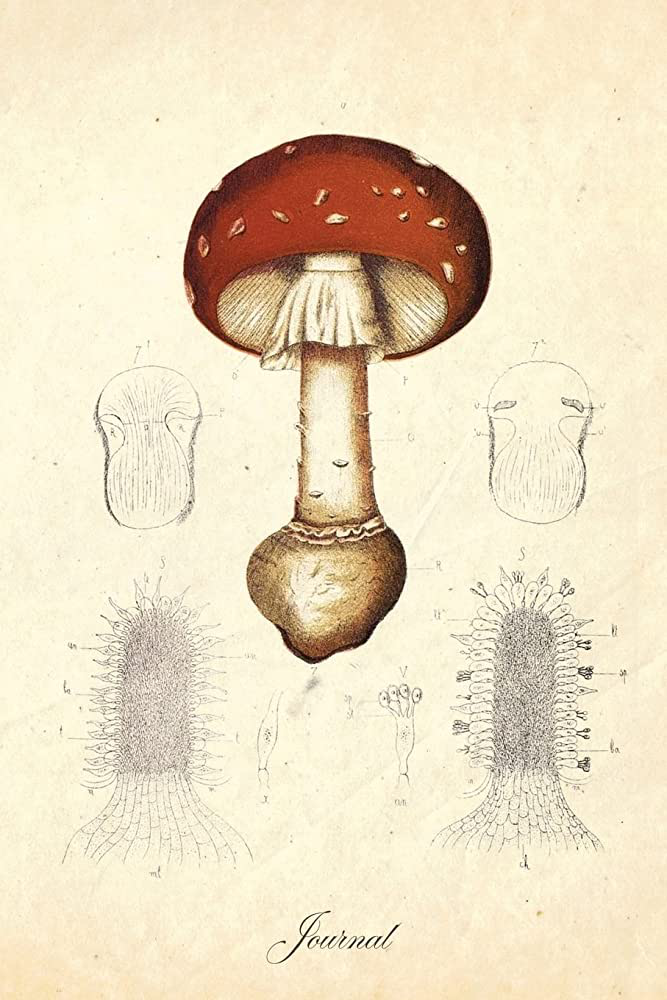

In [12]:
# example image
amanita_muscaria = list(data_dir.glob('anmanita muscaria - Google Search - 2_23_2023 11-37-51 AM/*'))
PIL.Image.open(str(amanita_muscaria[0]))

# Remove incompatible images

In [13]:
import cv2 # computer vision tools
import imghdr # helps determine the type of an image

In [14]:
# list of acceptable image extensions for later filtering
image_exts = ['jpeg', 'jpg', 'bmp', 'png','svg']

In [15]:
os.listdir(data_dir)

['king bolete - Google Search - 2_25_2023 4-52-16 PM',
 'cantharellus cibarius - Google Search - 2_23_2023 12-04-53 PM',
 'anmanita muscaria - Google Search - 2_23_2023 11-37-51 AM']

In [19]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [20]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

444


# 3. Create a dataset

In [21]:
batch_size = 32
img_height = 250
img_width = 250

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 416 files belonging to 3 classes.
Using 333 files for training.
Metal device set to: Apple M1 Max


2023-02-26 18:11:24.203578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-26 18:11:24.203749: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 416 files belonging to 3 classes.
Using 83 files for validation.


In [24]:
class_names = train_ds.class_names
print(class_names)

['anmanita muscaria - Google Search - 2_23_2023 11-37-51 AM', 'cantharellus cibarius - Google Search - 2_23_2023 12-04-53 PM', 'king bolete - Google Search - 2_25_2023 4-52-16 PM']


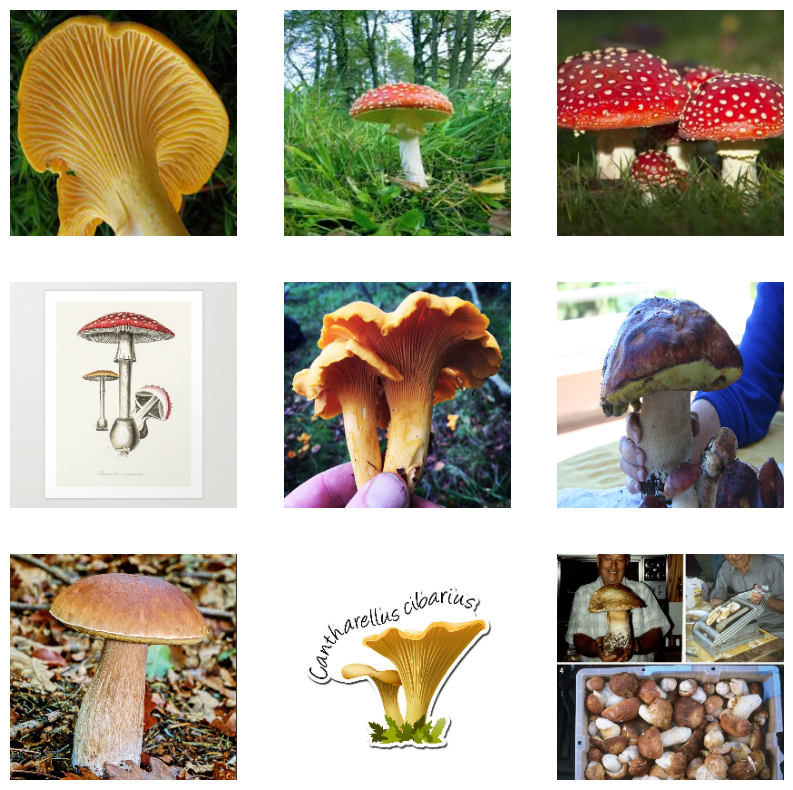

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


# Standardize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1

In [31]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-02-26 18:11:35.354180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 1.7752 - accuracy: 0.3844

2023-02-26 18:11:40.084568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 5s 172ms/step - loss: 1.7752 - accuracy: 0.3844 - val_loss: 1.0710 - val_accuracy: 0.5663
Epoch 2/10
11/11 [==============================] - 2s 80ms/step - loss: 0.9817 - accuracy: 0.5616 - val_loss: 0.9763 - val_accuracy: 0.5060
Epoch 3/10
11/11 [==============================] - 2s 79ms/step - loss: 0.7616 - accuracy: 0.6967 - val_loss: 1.4052 - val_accuracy: 0.3735
Epoch 4/10
11/11 [==============================] - 2s 80ms/step - loss: 0.7566 - accuracy: 0.6486 - val_loss: 0.8174 - val_accuracy: 0.6988
Epoch 5/10
11/11 [==============================] - 2s 82ms/step - loss: 0.5227 - accuracy: 0.8529 - val_loss: 1.0537 - val_accuracy: 0.6145
Epoch 6/10
11/11 [==============================] - 2s 78ms/step - loss: 0.4574 - accuracy: 0.8168 - val_loss: 0.6378 - val_accuracy: 0.7470
Epoch 7/10
11/11 [==============================] - 2s 81ms/step - loss: 0.3768 - accuracy: 0.8739 - val_loss: 0.6336 - val_accuracy: 0.7711
Epoch 8/10
11/11 [=====

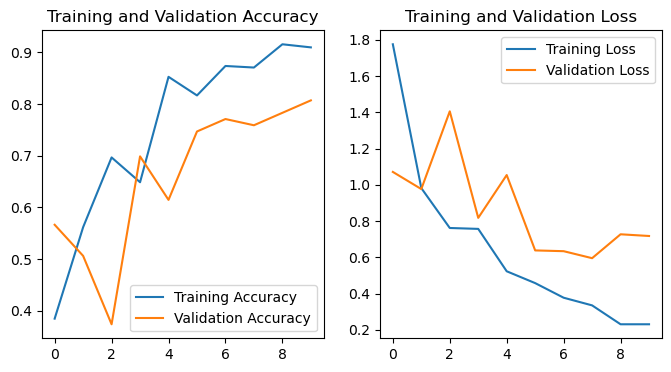

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data_gp')

In [ ]:
data.class_names

In [ ]:
type(data)

In [ ]:
for data in data:
    print(data,type(data))

In [ ]:
data

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
data_iterator

In [ ]:
batch = data_iterator.next()

In [ ]:
batch.shape

In [ ]:
len(batch[1])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Split Data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

# Split Data

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
train_size

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [ ]:
train

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

In [ ]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

# 7. Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
pip install tensorflow-macos==2.10

In [ ]:
pip install tensorflow-metal==0.6

In [ ]:
train[0]

In [ ]:
with tf.device('/device:GPU:0'):
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
train

In [ ]:
with tf.device('/cpu:0'):
    hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
with tf.device('/device:GPU:0'):
    model.fit(x_train, y_train)

In [ ]:
train